In [1]:
from src.constants import DATA_PATH, USER_PATH, SEKI_HULL, SIERRAS, PROJECTED_CALIFORNIA
from src.data.pipelines.extract_gedi_data import SIERRAS_GEDI_ID_COLUMNS, SIERRAS_GEDI_ALL_COLUMNS
from fastai.tabular.all import load_pickle, save_pickle
from src.data.processing import overlay
import geopandas as gpd
from src.data.adapters import mtbs
import numpy as np
from src.placebo import placebo
from src.data.utils import gedi_utils
from src.data.pipelines import aggregate_analysis as aa
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", palette="Set2")
palette = sns.color_palette("Set2")
from src.data.processing import gedi_raster_matching
from src.data.processing import advanced_landsat_overlay as alo
from pathlib import Path

import importlib
importlib.reload(placebo)
importlib.reload(alo)

2024-02-09 19:51:00,567 DEBUG: Logger /home/jk871/fire-regen/src/data/utils/raster.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2024-02-09 19:51:00,569 DEBUG: Logger /home/jk871/fire-regen/src/placebo/placebo.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2024-02-09 19:51:00,570 DEBUG: Logger /home/jk871/fire-regen/src/data/utils/raster.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2024-02-09 19:51:00,570 DEBUG: Logger /home/jk871/fire-regen/src/data/processing/advanced_landsat_overlay.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


<module 'src.data.processing.advanced_landsat_overlay' from '/home/jk871/fire-regen/src/data/processing/advanced_landsat_overlay.py'>

In [2]:
OUTPUT_PATH = f"{DATA_PATH}/evaluation/placebo_sets"
INPUT_PATH = f"{aa.PIPELINES_PATH}"
INFERENCE_PATH =  f"{DATA_PATH}/evaluation/inference"
PLACEBO_FOLDERS = ["set1", "set2", "set3", "set4", "set5", "small_fires", "large_fires"]

In [3]:
def get_placebo_sets(folder_name):
    placebo_set = load_pickle(f"{OUTPUT_PATH}/{folder_name}/placebo.pkl")
    calibration_set = load_pickle(f"{OUTPUT_PATH}/{folder_name}/callibration.pkl")
    return placebo_set, calibration_set

In [4]:
df_in = load_pickle(f"{INPUT_PATH}/severity_aggregated_info_da.pkl")
unburned = df_in[df_in.YSF < 0][["geometry"]]

In [5]:
GEDI_VARIABLES = ['agbd', 'cover', 'fhd_normal', 'pai', 'rh_25', 'rh_50', 'rh_70', 'rh_98']
TERRAIN_VARIABLES = ['slope', 'elevation', 'aspect']

In [14]:
sierras_all = sierras_all.set_index('shot_number')

In [12]:
sierra_fires = mtbs.get_mtbs_perimeters_for_sierras()

In [6]:
def save_placebo_set(path, placebo, callibration):
    PLACEBO_FILE_NAME = "placebo.pkl"
    CALLIBRATION_FILE_NAME = "callibration.pkl"

    save_pickle(f"{path}/{PLACEBO_FILE_NAME}", placebo)
    save_pickle(f"{path}/{CALLIBRATION_FILE_NAME}", callibration)

## Create 5 Random Placebo Sets

In [ ]:
for i in range(5):
    placebo, callibration = placebo.create_placebo_test_set(
        unburned,
        sierra_fires,
        lambda x, y: save_placebo_set(f"{OUTPUT_PATH}/set{i+1}", x, y)
        )

### Create size-dependend Placebo Sets - one for small and one for large fires

These sets should indicate how sensitive our algorithms are to fire size.

In [ ]:
small_fires = sierra_fires[sierra_fires.fire_size_acres < sierra_fires.fire_size_acres.quantile(0.1)]
large_fires = sierra_fires[sierra_fires.fire_size_acres > sierra_fires.fire_size_acres.quantile(0.9)]

In [36]:
placebo, callibration = placebo.create_placebo_test_set(
    unburned,
    small_fires,
    lambda x, y: save_placebo_set(f"{OUTPUT_PATH}/small_fires", x, y)
    )

2024-01-28 04:30:02,756 INFO: Converting all dataframes to projected CRS [in create_placebo_test_set at /home/jk871/fire-regen/src/placebo/placebo.py:51]
2024-01-28 04:30:08,679 INFO: Creating placebo and callibration set. [in create_placebo_test_set at /home/jk871/fire-regen/src/placebo/placebo.py:55]
2024-01-28 04:30:08,681 INFO: Create placebo test - entry [in _create_placebo_test_set at /home/jk871/fire-regen/src/placebo/placebo.py:71]
2024-01-28 04:30:08,786 INFO: Size of constructed placebo dataset: 0 [in _create_placebo_test_set at /home/jk871/fire-regen/src/placebo/placebo.py:79]
2024-01-28 04:30:08,830 INFO: Placebo sample radius size: 14973    1210.281769
dtype: float64 [in _create_placebo_test_set at /home/jk871/fire-regen/src/placebo/placebo.py:85]
2024-01-28 04:30:10,298 INFO: Size of the updated placebo dataset: 262 [in _create_placebo_test_set at /home/jk871/fire-regen/src/placebo/placebo.py:102]
2024-01-28 04:30:10,299 INFO: Size of the remaining dataset: 2102982 [in _c

TypeError: cannot unpack non-iterable NoneType object

In [38]:
placebo, callibration = placebo.create_placebo_test_set(
    unburned,
    large_fires,
    lambda x, y: save_placebo_set(f"{OUTPUT_PATH}/large_fires", x, y)
    )

2024-01-28 05:01:31,599 INFO: Converting all dataframes to projected CRS [in create_placebo_test_set at /home/jk871/fire-regen/src/placebo/placebo.py:51]
2024-01-28 05:01:36,854 INFO: Creating placebo and callibration set. [in create_placebo_test_set at /home/jk871/fire-regen/src/placebo/placebo.py:55]
2024-01-28 05:01:36,857 INFO: Create placebo test - entry [in _create_placebo_test_set at /home/jk871/fire-regen/src/placebo/placebo.py:73]
2024-01-28 05:01:36,967 INFO: Size of constructed placebo dataset: 0 [in _create_placebo_test_set at /home/jk871/fire-regen/src/placebo/placebo.py:81]
2024-01-28 05:01:37,015 INFO: Placebo sample radius size: 24750    6132.100774
dtype: float64 [in _create_placebo_test_set at /home/jk871/fire-regen/src/placebo/placebo.py:87]
2024-01-28 05:01:38,535 INFO: Size of the updated placebo dataset: 6580 [in _create_placebo_test_set at /home/jk871/fire-regen/src/placebo/placebo.py:104]
2024-01-28 05:01:38,536 INFO: Size of the remaining dataset: 2096664 [in _

### Visualize Placebo Sets

In [39]:
SIERRAS = gpd.read_file(SIERRAS)

In [45]:
def plot_placebo(df):
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    SIERRAS.plot(ax=ax)
    unburned.plot(ax=ax, color="yellow")
    df.plot(ax=ax, color="red")

### Set 1

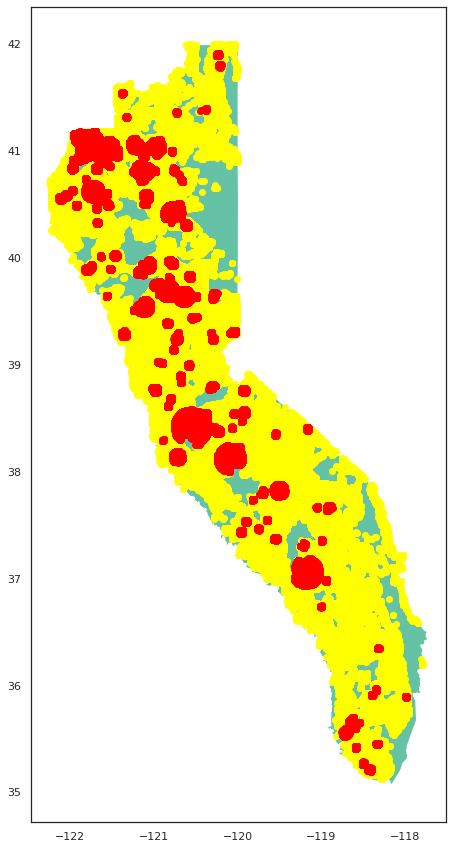

In [46]:
placebo_set = load_pickle(f"{OUTPUT_PATH}/set1/placebo.pkl")
plot_placebo(placebo_set)

### Set 2

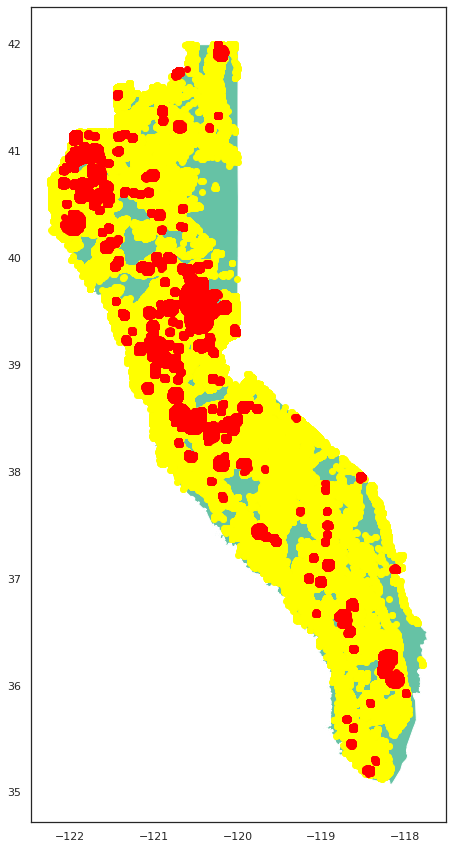

In [47]:
placebo_set = load_pickle(f"{OUTPUT_PATH}/set2/placebo.pkl")
plot_placebo(placebo_set)

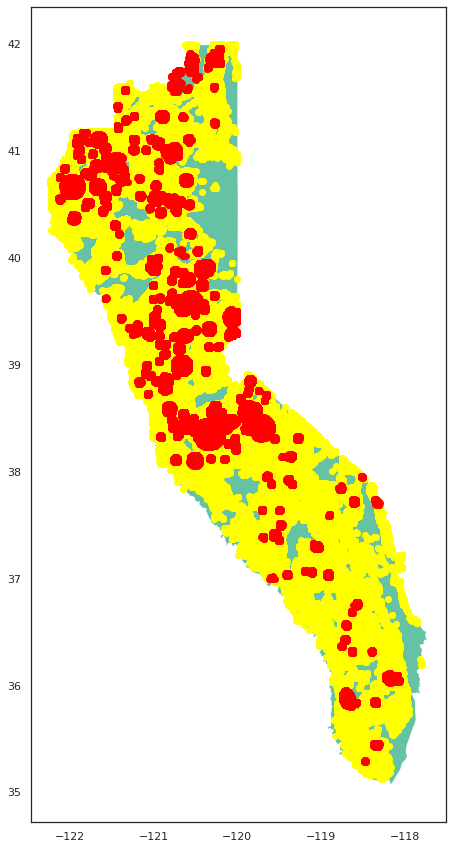

In [48]:
placebo_set = load_pickle(f"{OUTPUT_PATH}/set3/placebo.pkl")
plot_placebo(placebo_set)

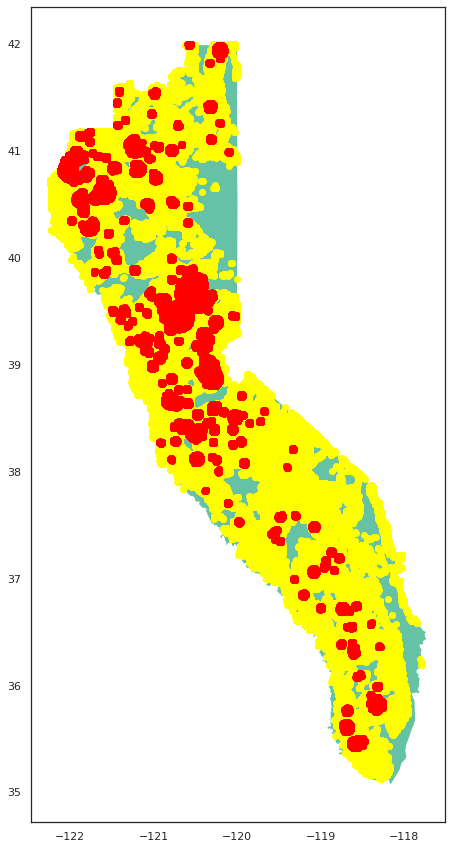

In [49]:
placebo_set = load_pickle(f"{OUTPUT_PATH}/set4/placebo.pkl")
plot_placebo(placebo_set)

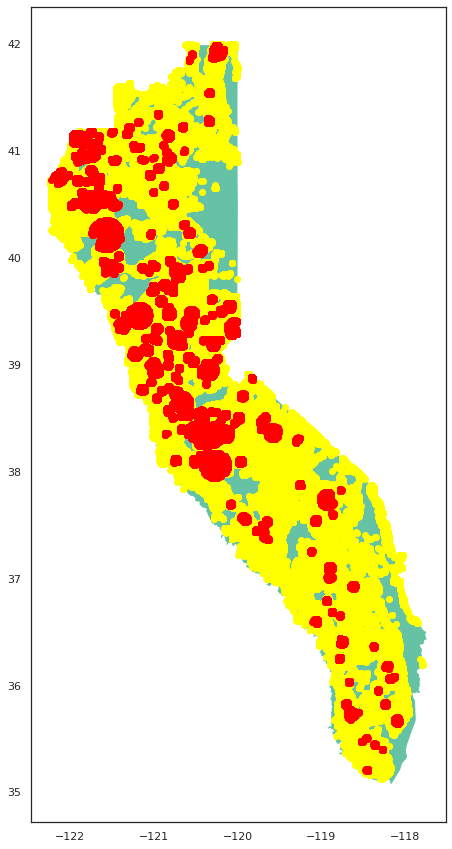

In [50]:
placebo_set = load_pickle(f"{OUTPUT_PATH}/set5/placebo.pkl")
plot_placebo(placebo_set)

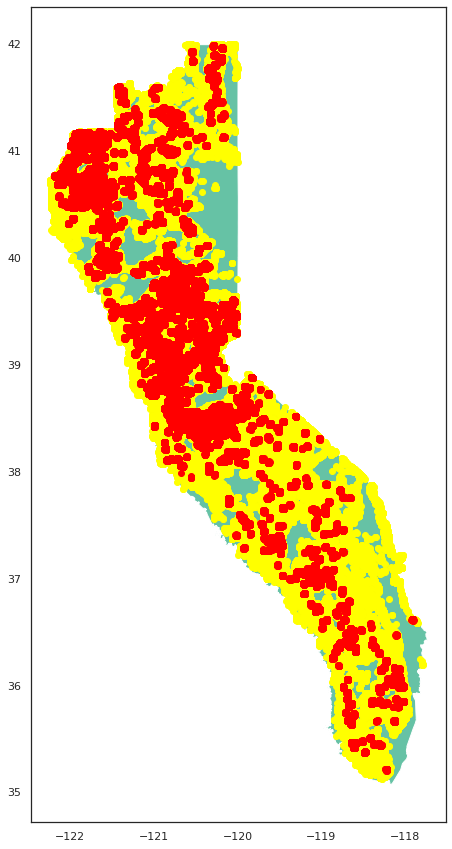

In [51]:
placebo_set = load_pickle(f"{OUTPUT_PATH}/small_fires/placebo.pkl")
plot_placebo(placebo_set)

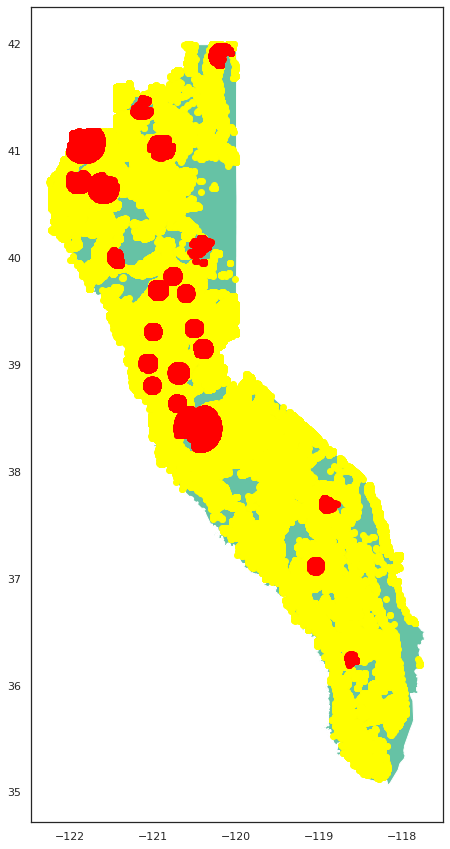

In [52]:
placebo_set = load_pickle(f"{OUTPUT_PATH}/large_fires/placebo.pkl")
plot_placebo(placebo_set)

# Create training and test sets from placebo sets

These expand dataframes with feature variables and dependent variables of interest, so that our algorithms can do training / calibration and inference on them.

Since we're trying out many different data and algo configurations, we make a bunch of different ones.

## Join Placebo with GEDI metrics

Placebo and callibration data sets are just two groups of divided GEDI IDs, each GEDI ID being in exactly one of the two. 

Ultimately though, we want to operate on variables of interest: NDVI or GEDI metrics. So, for the downstream processing, we need dataframes that include NDVI, PAI, RH_98 etc.

In [7]:
OUTCOME_VARIABLES = ['agbd', 'cover', 'fhd_normal', 'pai', 'rh_25', 'rh_50', 'rh_70', 'rh_98', 'ndvi']

In [8]:
unburned = df_in[df_in.YSF < 0]

In [14]:
for folder in PLACEBO_FOLDERS:
    placebo_set, calibration_set = get_placebo_sets(folder)

    placebo_set = placebo_set.join(unburned[OUTCOME_VARIABLES], how="left")
    calibration_set = calibration_set.join(unburned[OUTCOME_VARIABLES], how="left")

    save_pickle(f"{OUTPUT_PATH}/{folder}/placebo_aug.pkl", placebo_set)
    save_pickle(f"{OUTPUT_PATH}/{folder}/calibration_aug.pkl", calibration_set)


## Join Placebo with GEDI + Terrain + NDVI timeseries for Matching

In [ ]:
GEDI_VARIABLES = ['agbd', 'cover', 'fhd_normal', 'pai', 'rh_25', 'rh_50', 'rh_70', 'rh_98']
TERRAIN_VARIABLES = ['slope', 'elevation', 'aspect']
TS_NDVIS = ["ndvi_2019", "ndvi_2018", "ndvi_2017", "ndvi_2016", "ndvi_2015", "ndvi_2020", "ndvi_2021", "ndvi_2022", "ndvi_2010"]

In [11]:
unburned = df_in[df_in.YSF < 0]

In [10]:
ndvis = load_pickle(f"{DATA_PATH}/intermediate/overlays/ndvi_timeseries_overlay.pkl")

In [54]:
for folder in PLACEBO_FOLDERS:
    placebo_set, calibration_set = get_placebo_sets(folder)

    placebo_set = placebo_set.join(unburned[GEDI_VARIABLES + TERRAIN_VARIABLES], how="left")
    calibration_set = calibration_set.join(unburned[GEDI_VARIABLES + TERRAIN_VARIABLES], how="left")

    placebo_set = placebo_set.join(ndvis[TS_NDVIS], how="left")
    calibration_set = calibration_set.join(ndvis[TS_NDVIS], how="left")

    save_pickle(f"{OUTPUT_PATH}/{folder}/placebo_aug_ndvis.pkl", placebo_set)
    save_pickle(f"{OUTPUT_PATH}/{folder}/calibration_aug_ndvis.pkl", calibration_set)


## Dataset with all unburned pixels - not filtered for land cover.

In [12]:
set1 = load_pickle(f"{OUTPUT_PATH}/set1/placebo.pkl")

In [13]:
unburned = load_pickle(f"{INPUT_PATH}/unburned_aggregated_info.pkl")

In [6]:
unburned = unburned[unburned.YSF < 0]

In [14]:
calibration_extra_ext = unburned[~unburned.index.isin(set1.index)]

In [15]:
save_pickle(f"{OUTPUT_PATH}/set1/calibration_extra_ext.pkl", calibration_extra_ext[["geometry"]])

## Join Placebo with GEDI + Terrain + Landsat timeseries

In [10]:
GEDI_VARIABLES = ['agbd', 'cover', 'fhd_normal', 'pai', 'rh_25', 'rh_50', 'rh_70', 'rh_98']#, 'gridded_pft_class']
TERRAIN_VARIABLES = ['slope', 'elevation', 'aspect']
year = 2003
years = list(range(year - 4, year + 1))
TS_LANDSAT = []
for year in years:
    for band in gedi_raster_matching.get_landsat_bands(year):
        TS_LANDSAT.append(f"{band}_{year}")

In [7]:
unburned = df_in[df_in.YSF < 0]

In [11]:
for folder in ["set1"]:
    placebo_set, calibration_set = get_placebo_sets(folder)

    placebo_set = placebo_set.join(unburned[GEDI_VARIABLES + TERRAIN_VARIABLES], how="left")
    calibration_set = calibration_set.join(unburned[GEDI_VARIABLES + TERRAIN_VARIABLES], how="left")

    placebo_set = placebo_set.join(tcc[ttc_columns], how="left")
    calibration_set = calibration_set.join(tcc[ttc_columns], how="left")

    for year in years:
        landsat = load_pickle(f"{DATA_PATH}/intermediate/overlays/landsat_overlay_{year}.pkl")
        cols = [f"{band}_{year}" for band in gedi_raster_matching.get_landsat_bands(year)]
        placebo_set = placebo_set.join(landsat[cols], how="left")
        calibration_set = calibration_set.join(landsat[cols], how="left")
    
    save_pickle(f"{OUTPUT_PATH}/{folder}/placebo_aug_landsat_{year}_5.pkl", placebo_set)
    save_pickle(f"{OUTPUT_PATH}/{folder}/calibration_aug_landsat_{year}_5.pkl", calibration_set)

## Join Placebo with GEDI + Terrain + Advanced Landsat

In [24]:
# Join all advanced landsat metrics.
for folder in ["set1"]:
    placebo_set, calibration_set = get_placebo_sets(folder)

    placebo_set = placebo_set.join(unburned[GEDI_VARIABLES + TERRAIN_VARIABLES], how="left")
    calibration_set = calibration_set.join(unburned[GEDI_VARIABLES + TERRAIN_VARIABLES], how="left")

    for kind in ["mean", "min", "max", "stddev", "qt_25", "qt_50", "qt_75"]:
        landsat = load_pickle(f"{DATA_PATH}/intermediate/overlays/advanced_landsat_overlay_{kind}.pkl")
        cols = [f"{band}_{kind}" for band in alo.BANDS]
        placebo_set = placebo_set.join(landsat[cols], how="left")
        calibration_set = calibration_set.join(landsat[cols], how="left")
    
    save_pickle(f"{OUTPUT_PATH}/{folder}/placebo_aug_advanced_landsat.pkl", placebo_set)
    save_pickle(f"{OUTPUT_PATH}/{folder}/calibration_aug__advanced_landsat.pkl", calibration_set)

Index(['longitude', 'latitude', 'absolute_time', 'geometry', 'index_right',
       'SR_B1_mean', 'SR_B2_mean', 'SR_B3_mean', 'SR_B4_mean', 'SR_B5_mean',
       'SR_B6_mean', 'SR_B7_mean', 'NDVI_mean', 'NDWI_mean', 'NBR_mean',
       'NDMI_mean', 'SWIRS_mean', 'SVVI_mean', 'brightness_mean',
       'greenness_mean', 'wetness_mean'],
      dtype='object')
Index(['longitude', 'latitude', 'absolute_time', 'geometry', 'index_right',
       'SR_B1_min', 'SR_B2_min', 'SR_B3_min', 'SR_B4_min', 'SR_B5_min',
       'SR_B6_min', 'SR_B7_min', 'NDVI_min', 'NDWI_min', 'NBR_min', 'NDMI_min',
       'SWIRS_min', 'SVVI_min', 'brightness_min', 'greenness_min',
       'wetness_min'],
      dtype='object')
Index(['longitude', 'latitude', 'absolute_time', 'geometry', 'index_right',
       'SR_B1_max', 'SR_B2_max', 'SR_B3_max', 'SR_B4_max', 'SR_B5_max',
       'SR_B6_max', 'SR_B7_max', 'NDVI_max', 'NDWI_max', 'NBR_max', 'NDMI_max',
       'SWIRS_max', 'SVVI_max', 'brightness_max', 'greenness_max',
       'w

## Monthly Landsat + extended unburned

In [21]:
# Join all advanced landsat metrics.
for folder in ["set1"]:
    calibration_set = load_pickle(f"{OUTPUT_PATH}/{folder}/calibration_ext.pkl")

    calibration_set = calibration_set.join(unburned[GEDI_VARIABLES + TERRAIN_VARIABLES], how="left")

    for month in range(1, 13):
        landsat = load_pickle(f"{DATA_PATH}/intermediate/overlays/monthly_landsat_overlay_{month}.pkl")
        cols = [f"{band}_{month}" for band in alo.MONTHLY_BANDS]
        calibration_set = calibration_set.join(landsat[cols], how="left")
    
    save_pickle(f"{OUTPUT_PATH}/{folder}/calibration_ext_aug_monthly_landsat.pkl", calibration_set)

Index(['longitude', 'latitude', 'absolute_time', 'geometry', 'index_right',
       'SR_B1_1', 'SR_B2_1', 'SR_B3_1', 'SR_B4_1', 'SR_B5_1', 'SR_B6_1',
       'SR_B7_1', 'NDVI_1'],
      dtype='object')
Index(['longitude', 'latitude', 'absolute_time', 'geometry', 'index_right',
       'SR_B1_2', 'SR_B2_2', 'SR_B3_2', 'SR_B4_2', 'SR_B5_2', 'SR_B6_2',
       'SR_B7_2', 'NDVI_2'],
      dtype='object')
Index(['longitude', 'latitude', 'absolute_time', 'geometry', 'index_right',
       'SR_B1_3', 'SR_B2_3', 'SR_B3_3', 'SR_B4_3', 'SR_B5_3', 'SR_B6_3',
       'SR_B7_3', 'NDVI_3'],
      dtype='object')
Index(['longitude', 'latitude', 'absolute_time', 'geometry', 'index_right',
       'SR_B1_4', 'SR_B2_4', 'SR_B3_4', 'SR_B4_4', 'SR_B5_4', 'SR_B6_4',
       'SR_B7_4', 'NDVI_4'],
      dtype='object')
Index(['longitude', 'latitude', 'absolute_time', 'geometry', 'index_right',
       'SR_B1_5', 'SR_B2_5', 'SR_B3_5', 'SR_B4_5', 'SR_B5_5', 'SR_B6_5',
       'SR_B7_5', 'NDVI_5'],
      dtype='object')


## Monthly Landsat

In [5]:
unburned = df_in[df_in.YSF < 0]

In [4]:
placebo_set, calibration_set = get_placebo_sets("set1")

In [5]:
unburned_ext = load_pickle(f"{INPUT_PATH}/unburned_aggregated_info_da.pkl")

In [6]:
calibration_set = unburned_ext[~unburned_ext.index.isin(placebo_set.index)]

In [ ]:
# Join all monthly landsat metrics.
year = 2003
bands = gedi_raster_matching.get_landsat_bands(year)
for folder in ["set1"]:

    all_files = list(Path(f"{DATA_PATH}/intermediate/overlays/").iterdir())
    monthly_overlays = [filename for filename in all_files
                       if filename.name.startswith(f"monthly_landsat_overlay_{year}")]
    for filename in monthly_overlays:
        landsat = load_pickle(filename)
        cols = [col for col in landsat if (col.startswith("SR_") or col.startswith("NDVI"))]
        calibration_set = calibration_set.join(landsat[cols], how="left")
    
    save_pickle(f"{OUTPUT_PATH}/{folder}/calibration_extra_ext_da_aug_monthly_landsat_{year}.pkl", calibration_set)

In [ ]:
# Join all monthly landsat metrics.
year = 2003
bands = gedi_raster_matching.get_landsat_bands(year)
for folder in ["set1", "small_fires", "large_fires"]:
    placebo_set, calibration_set = get_placebo_sets(folder)

    placebo_set = placebo_set.join(unburned[GEDI_VARIABLES + TERRAIN_VARIABLES], how="left")
    calibration_set = calibration_set.join(unburned[GEDI_VARIABLES + TERRAIN_VARIABLES], how="left")

    all_files = list(Path(f"{DATA_PATH}/intermediate/overlays/").iterdir())
    monthly_overlays = [filename for filename in all_files
                       if filename.name.startswith(f"monthly_landsat_overlay_{year}")]
    for filename in monthly_overlays:
        landsat = load_pickle(filename)
        cols = [col for col in landsat if (col.startswith("SR_") or col.startswith("NDVI"))]
        placebo_set = placebo_set.join(landsat[cols], how="left")
        calibration_set = calibration_set.join(landsat[cols], how="left")
    
    save_pickle(f"{OUTPUT_PATH}/{folder}/placebo_aug_monthly_landsat_{year}.pkl", placebo_set)
    save_pickle(f"{OUTPUT_PATH}/{folder}/calibration_aug_monthly_landsat_{year}.pkl", calibration_set)

In [11]:
# Join all monthly landsat metrics.
year = 2003
bands = gedi_raster_matching.get_landsat_bands(year)
for folder in ["set1", "small_fires", "large_fires"]:
    placebo_set, calibration_set = get_placebo_sets(folder)

    placebo_set = placebo_set.join(unburned[GEDI_VARIABLES + TERRAIN_VARIABLES], how="left")
    calibration_set = calibration_set.join(unburned[GEDI_VARIABLES + TERRAIN_VARIABLES], how="left")

    all_files = list(Path(f"{DATA_PATH}/intermediate/overlays/").iterdir())
    monthly_overlays = [filename for filename in all_files
                       if filename.name.startswith(f"monthly_landsat_overlay_{year}")]
    for filename in monthly_overlays:
        landsat = load_pickle(filename)
        cols = [col for col in landsat if (col.startswith("SR_") or col.startswith("NDVI"))]
        placebo_set = placebo_set.join(landsat[cols], how="left")
        calibration_set = calibration_set.join(landsat[cols], how="left")
    
    save_pickle(f"{OUTPUT_PATH}/{folder}/placebo_aug_monthly_landsat_{year}.pkl", placebo_set)
    save_pickle(f"{OUTPUT_PATH}/{folder}/calibration_aug_monthly_landsat_{year}.pkl", calibration_set)

In [8]:
tcc = load_pickle(f"{overlay.OVERLAYS_PATH}/tree_canopy_cover_overlay.pkl")
ttc_columns = ["tcc_2000", "tcc_2005", "tcc_2010", "tcc_2015"]

In [ ]:
# Add Tree Cover columns
year = 2003
for folder in ["set1"]:
    placebo_set = load_pickle(f"{OUTPUT_PATH}/{folder}/placebo_aug_monthly_landsat_{year}.pkl")
    calibraction_set = load_pickle(f"{OUTPUT_PATH}/{folder}/calibration_aug_monthly_landsat_{year}.pkl")

    placebo_set = placebo_set.join(tcc[ttc_columns], how="left")
    calibration_set = calibration_set.join(tcc[ttc_columns], how="left")

    save_pickle(f"{OUTPUT_PATH}/{folder}/placebo_aug_monthly_landsat_{year}.pkl", placebo_set)
    save_pickle(f"{OUTPUT_PATH}/{folder}/calibration_aug_monthly_landsat_{year}.pkl", calibration_set)


In [11]:
# Add Tree Cover columns
year = 2003
for folder in ["set1"]:
    placebo_set = load_pickle(f"{OUTPUT_PATH}/{folder}/placebo_aug_monthly_landsat.pkl")
    calibration_set = load_pickle(f"{OUTPUT_PATH}/{folder}/calibration_aug_monthly_landsat.pkl")

    placebo_set = placebo_set.join(tcc[ttc_columns], how="left")
    calibration_set = calibration_set.join(tcc[ttc_columns], how="left")

    save_pickle(f"{OUTPUT_PATH}/{folder}/placebo_aug_monthly_landsat_{year}.pkl", placebo_set)
    save_pickle(f"{OUTPUT_PATH}/{folder}/calibration_aug_monthly_landsat_{year}.pkl", calibration_set)


## Chunk Placebo Set

In [72]:
# Chunk Placebo Set 1
placebo_set_ndvis = load_pickle(f"{OUTPUT_PATH}/set1/placebo_aug_ndvis.pkl")
list_df = np.array_split(placebo_set_ndvis, 20)
for chunk in range(0, 20):
    save_pickle(f"{OUTPUT_PATH}/set1/placebo_aug_ndvis_{chunk}.pkl", list_df[chunk])

/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 

In [73]:
for chunk in range(20):
    print(f"python src/counterfactuals/matching/matching.py -n placebo_set_1_chunk_{chunk} -t /maps/fire-regen/data/evaluation/placebo_sets/set1/placebo_aug_ndvis_{chunk}.pkl -u /maps/fire-regen/data/evaluation/placebo_sets/set1/calibration_aug_ndvis.pkl -k 1 -p /maps/fire-regen/data/counterfactuals/matching &")

python src/counterfactuals/matching/matching.py -n placebo_set_1_chunk_0 -t /maps/fire-regen/data/evaluation/placebo_sets/set1/placebo_aug_ndvis_0.pkl -u /maps/fire-regen/data/evaluation/placebo_sets/set1/calibration_aug_ndvis.pkl -k 1 -p /maps/fire-regen/data/counterfactuals/matching &
python src/counterfactuals/matching/matching.py -n placebo_set_1_chunk_1 -t /maps/fire-regen/data/evaluation/placebo_sets/set1/placebo_aug_ndvis_1.pkl -u /maps/fire-regen/data/evaluation/placebo_sets/set1/calibration_aug_ndvis.pkl -k 1 -p /maps/fire-regen/data/counterfactuals/matching &
python src/counterfactuals/matching/matching.py -n placebo_set_1_chunk_2 -t /maps/fire-regen/data/evaluation/placebo_sets/set1/placebo_aug_ndvis_2.pkl -u /maps/fire-regen/data/evaluation/placebo_sets/set1/calibration_aug_ndvis.pkl -k 1 -p /maps/fire-regen/data/counterfactuals/matching &
python src/counterfactuals/matching/matching.py -n placebo_set_1_chunk_3 -t /maps/fire-regen/data/evaluation/placebo_sets/set1/placebo_a

In [76]:
# Coalesce all chunks
all_chunks = []
for chunk in range(20):
    all_chunks.append(load_pickle(f"/maps/fire-regen/data/counterfactuals/matching/matching_placebo_set_1_chunk_{chunk}_1.pkl"))
combined = pd.concat(all_chunks)

In [78]:
save_pickle(f"/maps/fire-regen/data/counterfactuals/matching/matching_placebo_set_1_1.pkl", combined)

## Mini Set for Debugging

Let's create a mini dataset for debugging purposes.

In [55]:
placebo_set = load_pickle(f"{OUTPUT_PATH}/set1/placebo_aug.pkl")
placebo_set_ndvis = load_pickle(f"{OUTPUT_PATH}/set1/placebo_aug_ndvis.pkl")

In [56]:
calibration_set_ndvis = load_pickle(f"{OUTPUT_PATH}/set1/calibration_aug_ndvis.pkl")

In [63]:
mini_set = placebo_set.head(1000)
mini_set_ndvis = placebo_set_ndvis.sample(1000)
mini_calibration_set_ndvis = calibration_set_ndvis#.head(10000000)

In [58]:
save_pickle(f"{OUTPUT_PATH}/mini_set/mini_set_calibration_ndvis.pkl", mini_calibration_set_ndvis)

In [59]:
save_pickle(f"{OUTPUT_PATH}/mini_set/mini_set.pkl", mini_set)

In [64]:
save_pickle(f"{OUTPUT_PATH}/mini_set/mini_set_ndvis.pkl", mini_set_ndvis)

## Inference Set

In [6]:
burned = df_in[df_in.YSF > 0]

In [8]:
unburned = df_in[df_in.YSF < 0]

In [7]:
save_pickle(f"{INFERENCE_PATH}/burned.pkl", burned)

In [9]:
save_pickle(f"{INFERENCE_PATH}/unburned.pkl", unburned)